Top 5 productos por valor total exportado (sin incluir 'total'):
soya       20896.3
otros      13331.1
castaña     3156.0
maderas     2208.8
joyería     2005.5
dtype: float64


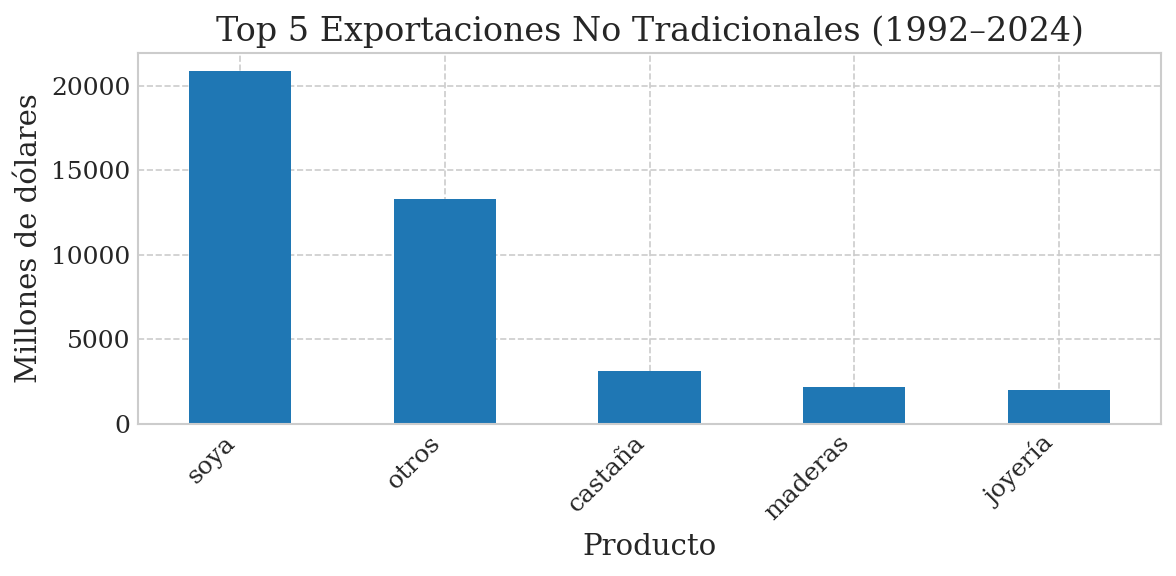

In [60]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import sqlite3, os
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_participation_cycle_boxes, add_cycle_means_multi, add_hitos,
    add_period_growth_annotations_multi, add_year_value_annotations
)

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql(
        "SELECT *FROM exportaciones_no_tradicionales",
        conn
    )
prod_cols = [c for c in df.columns if c not in ('año', 'total')]
totales = df.set_index('año')[prod_cols].sum().sort_values(ascending=False)

# Imprimimos top‐5
print("Top 5 productos por valor total exportado (sin incluir 'total'):")
print(totales.head(5))

# ── 4. Gráfica de los 5 principales ────────────────────────────────
fig, ax = plt.subplots(figsize=(8,4))
totales.head(5).plot.bar(ax=ax)
ax.set_title("Top 5 Exportaciones No Tradicionales (1992–2024)")
ax.set_ylabel("Millones de dólares")
ax.set_xlabel("Producto")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

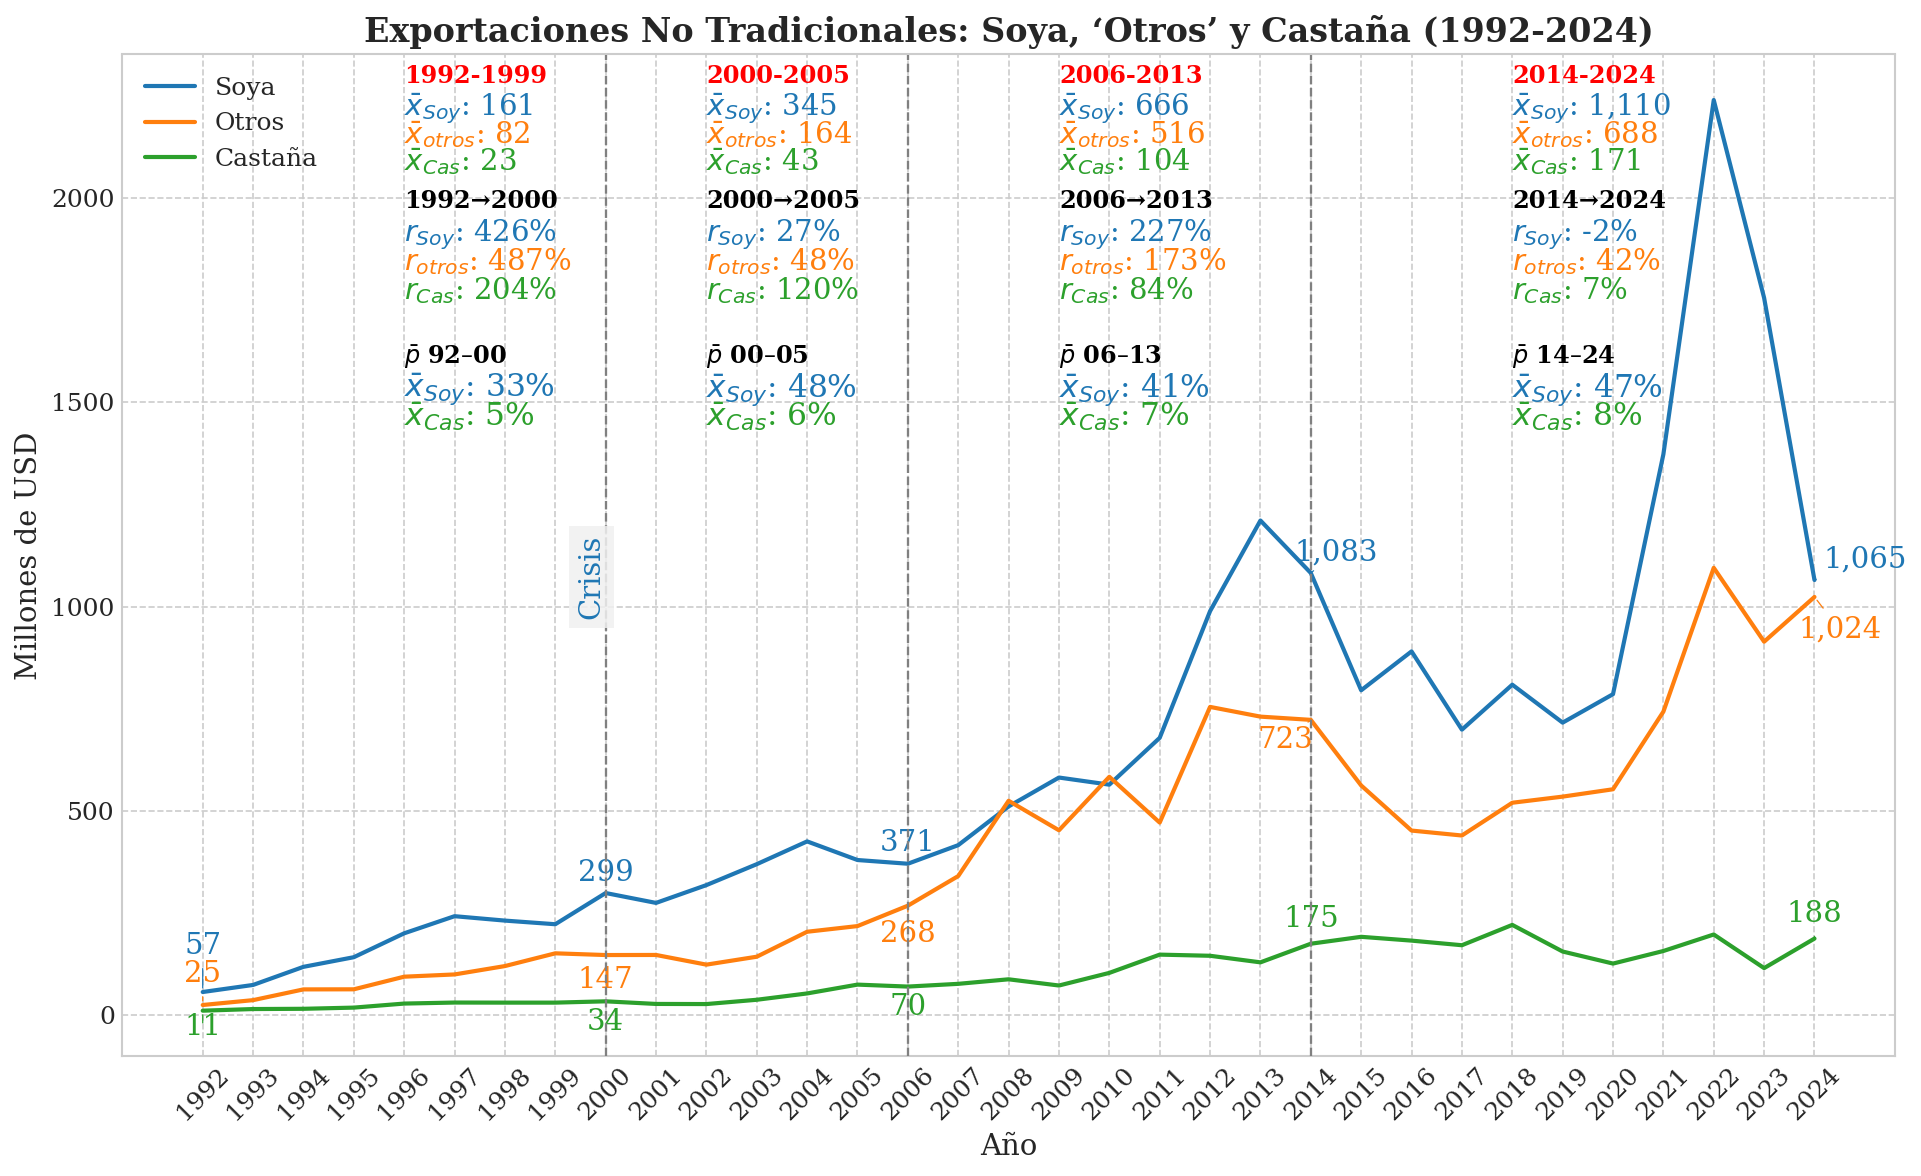

In [61]:
"""
Exportaciones No Tradicionales: soya, ‘otros’ y castaña  
(1992-2024, Millones USD) — gráfico con helpers de *graficos_utils*
"""

# ── 0. Imports ───────────────────────────────────────────────────────
import os, sqlite3, sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))          # ruta a graficos_utils.py
from graficos_utils import (
    add_hitos,
    add_cycle_means_multi,
    add_year_value_annotations,
    add_period_growth_annotations_multi,
    add_participation_cycle_boxes,
)

# ── 1. Configuración general ─────────────────────────────────────────
OUT = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUT, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family":"serif", "font.size":12,
    "axes.titlesize":16,   "axes.labelsize":14,
    "grid.linestyle":"--", "lines.linewidth":2,
    "figure.dpi":150,      "savefig.bbox":"tight",
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql("SELECT * FROM exportaciones_no_tradicionales",
                      conn, index_col="año")
            .sort_index())                 # 1992–2024

# aseguramos nombres coherentes ↓ (ajusta si tus columnas difieren)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

series = [
    ("soya",          "Soya"),
    ("otros","Otros"),     # «otros_productos» en la base
    ("castaña",       "Castaña"),
]
cols  = [c for c,_ in series]
cmap  = plt.get_cmap("tab10")
colors= {col: cmap(i) for i,(col,_) in enumerate(series)}
abbr  = {"soya":"Soy", "castaña":"Cas", "otros_productos":"Otr"}

# ── 3. Ciclos ────────────────────────────────────────────────────────
periods_for_means=[
    (1992, 1999),
    (2000, 2005),
    (2006, 2013),
    (2014, 2024),
]
periods = [
    (1992, 2000),    # sub-expansión 92-99
    (2000, 2005),    # crisis
    (2006, 2013),    # acumulación
    (2014, 2024),    # recesión
]
cycle_stats = {f"{vi}-{vf}": df.loc[vi:vf, cols].mean().to_dict()
               for vi,vf in periods_for_means}
cycle_offsets = {
    "1992-1999": (1996, 0.99),
    "2000-2005": (2002, 0.99),
    "2006-2013": (2009, 0.99),
    "2014-2024": (2018, 0.99),
}

# ── 4. Hitos, valores y crecimientos ─────────────────────────────────
hitos_v      = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset = {a:0.5 for a in hitos_v}

anot_years = [1992, 2000, 2006, 2014, 2024]
annotation_offsets = {
    "soya": {
        1992:(0,112), 2000:(0,50), 2006:(0,50),
        2014:(0.5,50), 2024:(1,50),
    },
    "otros": {
        1992:(0,75),2000:(0,-60),2006:(0,-70),
        2014:(-0.5,-50),2024:(0.5,-80),
    },
    "castaña": {
        1992:(0,-40),  2000:(0,-50),  2006:(0,-50),
        2014:(0,60),  2024:(0,60),
    },
}

growth_periods = periods
growth_offsets = {
    "1992-2000": (1996, 0.86),
    "2000-2005": (2002, 0.86),
    "2006-2013": (2009, 0.86),
    "2014-2024": (2018, 0.86),
}

# ── 5. Participación media (%) ───────────────────────────────────────
components   = ["soya", "castaña"]
total_col    = "total"       # en la tabla existe ‘total’
part_offsets = {
    "1992-2000": (1996, 0.7),
    "2000-2005": (2002, 0.7),
    "2006-2013": (2009, 0.7),
    "2014-2024": (2018, 0.7),
}

# ── 6. Gráfico ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13,8))

for col,label in series:
    ax.plot(df.index, df[col], label=label, color=colors[col])

# helpers
add_hitos(ax, df.index, hitos_v, hitos_offset)
add_cycle_means_multi(ax, cycle_stats, cycle_offsets,
                      abbr, colors, line_spacing=df[cols[0]].max()*0.03)
add_year_value_annotations(ax, df, anot_years,
                           cols, annotation_offsets, colors, arrow_lw=0.6)
add_period_growth_annotations_multi(ax, df, growth_periods,
                                    cols, growth_offsets, colors, abbr)
add_participation_cycle_boxes(
    ax, df, growth_periods, components, total_col,
    part_offsets, abbr_map=abbr,
    colors={c: colors[c] for c in components}
)

# ── 7. Etiquetas y salida ────────────────────────────────────────────
ax.set_title("Exportaciones No Tradicionales: Soya, ‘Otros’ y Castaña (1992-2024)",
             fontweight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Millones de USD")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis="x", rotation=45)
ax.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUT, "exportaciones_no_tradicionales_soya_otros_castaña.png"),
            dpi=300)
plt.show()
